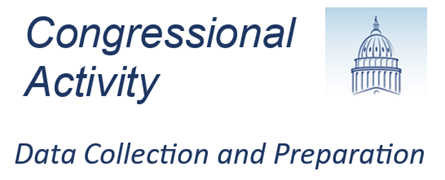

***  
# Introduction  
Since 1947, a summary of each Congressional session has been included in the Congressional Record, under the title Resume of Congressional Activity. The resume includes statistics on the number of measures introduced, bills passed, outcome of confirmations, etc.

The objective of this project is to create a dataset from published Resumes of Congressional Activity for analysis.

For this project, Resumes of Congressional Activity were downloaded in PDF form from <a href="https://www.senate.gov/">Senate.gov</a> and <a href="https://govinfo.gov">GovInfo.com</a>. Resumes from the 98th though 117th Congresses are included in this porject.

Additional information regarding the Resume of Congressional activity can be found at <a href="https://www.congress.gov/help/congressional-record">congress.gov</a>.

***
# Notebook Setup
***

In [1]:
# Import libraries
import pandas as pd
import re

In [2]:
# This notebook requires openpyxl. If you do not have this installed, uncomment the following install command
#!pip install openpyxl

In [3]:
# Set options
pd.options.display.multi_sparse = False

***  
# Read Raw Data
***
Given the complexity of scraping data from PDF, the contents of each resume were manually copied and pasted into Microsoft Excel. Minimal formatting was completed for consistency. The final dataset will be generated from the Excel document.

Individual resumes can be found on <a href="https://www.senate.gov/legislative/ResumesofCongressionalActivity1947present.htm">Senate.gov</a> 

<font color='red'>Note:</font> Not all of the resumes available on the Senate.gov page referenced above are final. Where the resume was not final, additional .gov sites were searched to find the lastest version. A copy of the actual PDFs used is avaiable on <a href="https://github.com/tamimcm416/congressional_activity">GitHub</a>.


In [4]:
# Read in all worksheets
file_name = '../Data/Resume Data - Raw.xlsx'
raw_data_dict = pd.read_excel(file_name, sheet_name=None, header=None, skiprows=3, usecols='A:G')

In [5]:
# View the naemes of each tab loaded from the Excel document
print(raw_data_dict.keys())

dict_keys(['1983 - 98.1', '1984 - 98.2', '1985 - 99.1', '1986 - 99.2', '1987 - 100.1', '1988 - 100.2', '1989 - 101.1', '1990 - 101.2', '1991 - 102.1', '1992 - 102.2', '1993 - 103.1', '1994 - 103.2', '1995 - 104.1', '1996 - 104.2', '1997 - 105.1', '1998 - 105.2', '1999 - 106.1', '2000 - 106.2', '2001 - 107.1', '2002 - 107.2', '2003 - 108.1', '2004 - 108.2', '2005 - 109.1', '2006 - 109.2', '2007 - 110.1', '2008 - 110.2', '2009 - 111.1', '2010 - 111.2', '2011 - 112.1', '2012 - 112.2', '2013 - 113.1', '2014 - 113.2', '2015 - 114.1', '2016 - 114.2', '2017 - 115.1', '2018 - 115.2', '2019 - 116.1', '2020 - 116.2', '2021 - 117.1', '2022 - 117.2'])


In [6]:
# View the contents of the first worksheet
pd.DataFrame(raw_data_dict['1983 - 98.1'])

,0,1,2,3,4,5,6
0,NaN,Senate,House,Total,NaN,NaN,NaN
1,Days in session,150,146,NaN,NaN,"Army nominations, totaling 14,784, disposed of...",NaN
2,Time in session,"1,010 hrs., 47'","851 hrs., 45'",NaN,NaN,...Confirmed,14782.0
3,Congressional Record:,NaN,NaN,NaN,NaN,...Failed at August-September adjournment,1.0
4,...Pages of proceedings,17224,10665,27889,NaN,...Failed at November 18 sine die adjournment,1.0
5,...Extension of Remarks,NaN,NaN,5985,NaN,NaN,NaN
6,Public bills enacted into law,101,114,215,NaN,"Navy nominations, totaling 21,994, disposed of...",NaN
7,Private bills enacted into law,NaN,6,6,NaN,...Confirmed,21994.0
8,Bills in conference,3,2,5,NaN,NaN,NaN
9,Bills through conference,4,29,33,NaN,"Air Force nominations, totaling 12,819, dispos...",NaN


***
# Create GA Dataframe
***
We'll pull all of the general data from the raw data dictionary and get it into a dataframe.

In [7]:
# Create an empty dataframe to hold the final data
gen_activity_df = pd.DataFrame(columns = ['Session', 'Label', 'Senate', 'House', 'Both'])

In [8]:
# Loop through the first column of each worksheet to tidy the label and pull the values for each label.
for key in raw_data_dict.keys():
    for i, row in raw_data_dict[key].iterrows():
        if pd.isna(row[0]) == False:
            new_label = row[0].capitalize()
            if '...' not in new_label:
                section = new_label.replace(':', '')
            else:
                new_label = section + '...' + new_label[3:].capitalize()
            gen_activity_df.loc[len(gen_activity_df)] = [key, new_label, row[1], row[2], row[3]]

In [9]:
# Let's preview the general activity dataframe
gen_activity_df.head()

,Session,Label,Senate,House,Both
0,1983 - 98.1,Days in session,150,146,NaN
1,1983 - 98.1,Time in session,"1,010 hrs., 47'","851 hrs., 45'",NaN
2,1983 - 98.1,Congressional record:,NaN,NaN,NaN
3,1983 - 98.1,Congressional record...Pages of proceedings,17224,10665,27889.0
4,1983 - 98.1,Congressional record...Extension of remarks,NaN,NaN,5985.0


***
# Tidy GA Dataframe
***
Let's rearrange our data so that it is tidy, with the columns representing variables and rows representing observations. In this case, we will consider each observation to be defined by the year and chamber.

In [10]:
# Let's start by pivoting our data so that each column is a variable. We will do this by chamber and concatenate
# the results to simplify the pivot
gen_activity_tidy_df = pd.DataFrame()
for chamber in ['Senate', 'House', 'Both']:
    temp_df = gen_activity_df[['Session', 'Label', chamber]].copy()
    temp_df = temp_df.pivot(index=['Session'], columns=['Label'], values=chamber)
    temp_df['Chamber'] = chamber
    gen_activity_tidy_df = pd.concat([gen_activity_tidy_df, temp_df], axis=0)

In [11]:
# Split the Session value into Year, Congress and Session
gen_activity_tidy_df.reset_index(inplace=True)
gen_activity_tidy_df[['Year', 'Congress', 'Session']] = gen_activity_tidy_df['Session'].str.split(' - |\.', expand=True)
cols = ['Year', 'Congress', 'Session', 'Chamber']
cols.extend(gen_activity_tidy_df.columns.to_list()[2:-3])
gen_activity_tidy_df = gen_activity_tidy_df[cols].copy()

# Review GA Dataframe
***
Review the dataframe for consistency of labeling and clarity, and update where appropriate. We will also do a cursory review of the data. A more thorough validation of the data will be performed in a future step.

In [12]:
# Let's look at the consistency of labels to see if we need to do any additional cleanup.
gen_activity_tidy_df.columns

Index(['Year', 'Congress', 'Session', 'Chamber', 'Bills not signed',
       'Bills through conference', 'Bills vetoed', 'Conference reports',
       'Congressional record...Extension of remarks',
       'Congressional record...Pages of proceedings', 'Congressional record:',
       'Days in session', 'Measures introduced, total',
       'Measures introduced, total...Bills',
       'Measures introduced, total...Concurrent resolutions',
       'Measures introduced, total...Joint resolutions',
       'Measures introduced, total...Simple resolutions',
       'Measures passed, total', 'Measures passed, total...House bills',
       'Measures passed, total...House concurrent resolutions',
       'Measures passed, total...House joint resolutions',
       'Measures passed, total...Senate bills',
       'Measures passed, total...Senate concurrent resolutions',
       'Measures passed, total...Senate joint resolutions',
       'Measures passed, total...Simple resolutions',
       'Measures pending

***  
Since we don't have any duplicate labels, we'll focus on clarity and consistency of formatting.
***  

In [13]:
# Remove the 'Congressional Record" prefix from the Pages of proceedings and Extension of remarks labels and delete
# the empty Congressional Record column that was created during our import of data
gen_activity_tidy_df.columns = gen_activity_tidy_df.columns.str.removeprefix('Congressional record...')
gen_activity_tidy_df.drop('Congressional record:', axis=1, inplace=True)

In [14]:
# Clean up the labels where we prepended the headings
gen_activity_tidy_df.columns = gen_activity_tidy_df.columns.str.replace(' total...', ' ', regex=True)

In [15]:
# let's simplify by dropping the minutes and removing the comma used as a thousands marker
gen_activity_tidy_df['Time in session'] = gen_activity_tidy_df['Time in session'].str.split(' ').str[0]
gen_activity_tidy_df['Time in session'] = gen_activity_tidy_df['Time in session'].str.replace(',', '')

In [16]:
# Replace all NaN values with 0
gen_activity_tidy_df.fillna(0, inplace=True)

In [17]:
# Convert all columns except Chamber to int
cols = gen_activity_tidy_df.columns.to_list()
cols.remove('Chamber')
gen_activity_tidy_df[cols] = gen_activity_tidy_df[cols].astype(int)

In [18]:
# Review data
gen_activity_tidy_df.head()

Label,Year,Congress,Session,Chamber,Bills not signed,Bills through conference,Bills vetoed,Conference reports,Extension of remarks,Pages of proceedings,...,"Measures reported, Senate joint resolutions","Measures reported, Simple resolutions",Private bills enacted into law,Public bills enacted into law,Quorum calls,Recorded votes,Special reports,Time in session,Vetoes overridden,Yea-and-nay votes
0,1983,98,1,Senate,0,4,3,4,0,17224,...,87,139,0,101,18,0,25,1010,1,381
1,1984,98,2,Senate,0,22,8,0,0,14650,...,99,122,17,166,19,0,11,940,1,292
2,1985,99,1,Senate,0,8,0,2,0,18418,...,118,100,0,110,20,0,18,1252,1,381
3,1986,99,2,Senate,0,0,4,0,0,17426,...,111,63,7,187,16,0,15,1278,1,359
4,1987,100,1,Senate,0,0,1,1,0,18660,...,72,62,2,96,36,0,28,1214,2,420


In [19]:
# Describe data
gen_activity_tidy_df.describe()

Label,Year,Congress,Session,Bills not signed,Bills through conference,Bills vetoed,Conference reports,Extension of remarks,Pages of proceedings,Days in session,...,"Measures reported, Senate joint resolutions","Measures reported, Simple resolutions",Private bills enacted into law,Public bills enacted into law,Quorum calls,Recorded votes,Special reports,Time in session,Vetoes overridden,Yea-and-nay votes
count,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,...,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000
mean,2002.500000,107.500000,1.500000,0.016667,2.050000,2.375000,7.008333,1071.625000,11309.666667,101.508333,...,7.866667,45.100000,3.700000,140.741667,5.525000,93.433333,15.383333,674.575000,0.308333,215.541667
std,11.591797,5.790459,0.502096,0.128556,7.832114,4.109964,13.211591,1528.214029,8510.161821,74.518059,...,23.541465,46.245127,7.810357,97.646205,9.659725,152.321075,18.351921,512.135957,0.658440,172.219271
min,1983.000000,98.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1992.750000,102.750000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7503.500000,0.000000,...,0.000000,0.000000,0.000000,72.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2002.500000,107.500000,1.500000,0.000000,0.000000,0.000000,0.000000,0.000000,11029.500000,134.500000,...,0.000000,29.000000,0.000000,120.500000,2.000000,0.000000,10.500000,868.500000,0.000000,268.000000
75%,2012.250000,112.250000,2.000000,0.000000,0.000000,3.000000,4.000000,2223.750000,15287.250000,159.000000,...,2.000000,93.000000,4.000000,198.250000,6.000000,195.750000,22.500000,1039.250000,0.000000,326.000000
max,2022.000000,117.000000,2.000000,1.000000,52.000000,21.000000,56.000000,5985.000000,35003.000000,211.000000,...,118.000000,149.000000,46.000000,473.000000,55.000000,671.000000,97.000000,1839.000000,4.000000,648.000000


***
# Create Confirm Dataframe
***
We'll pull all of the confirmation data from the raw data dictionary and get it into a dataframe.

In [20]:
# Create an empty dataframe to hold the final data
confirm_df = pd.DataFrame(columns = ['Session', 'Label', 'Value'])

In [21]:
# Loop through the data to pull labels and values for confirmations
for key in raw_data_dict.keys():
    for i, row in raw_data_dict[key].iterrows():
        if pd.isna(row[5]) == False:
            new_label = row[5].capitalize()
            if '...' not in new_label:
                section = new_label.replace(':', '')
            else:
                new_label = section.split(' nominations')[0] + '...' + new_label[3:].capitalize()
            confirm_df.loc[len(confirm_df)] = [key, new_label, row[6]]

In [22]:
# Let's preview the confirmation dataframe
with pd.option_context('display.max_colwidth', 400):
    display(confirm_df.head())

,Session,Label,Value
0,1983 - 98.1,"Army nominations, totaling 14,784, disposed of as follows:",NaN
1,1983 - 98.1,Army...Confirmed,14782.0
2,1983 - 98.1,Army...Failed at august-september adjournment,1.0
3,1983 - 98.1,Army...Failed at november 18 sine die adjournment,1.0
4,1983 - 98.1,"Navy nominations, totaling 21,994, disposed of as follows:",NaN


***
# Tidy Confirm Dataframe
***
Let's rearrange our data so that it is tidy, with the columns representing variables and rows representing observations. In this case, we will consider each observation to be defined by the year and session.

In [23]:
# Start by identifying variable names that contain values
labels_with_digits = []
for row in confirm_df['Label']:
    if any(char.isdigit() for char in row):
        labels_with_digits.append(row)
        continue
print(f'There are {len(labels_with_digits)} labels that contain values.')

There are 244 labels that contain values.


In [24]:
# Preview the list of labels that contain values:
labels_with_digits[0:10]

['Army nominations, totaling 14,784, disposed of as follows:',
 'Army...Failed at november 18 sine die adjournment',
 'Navy nominations, totaling 21,994, disposed of as follows:',
 'Air force nominations, totaling 12,819, disposed of as follows:',
 'Marine corps nominations, totaling 2,990, disposed of as follows:',
 'Civilian nominations, totaling 3,454, disposed of as follows:',
 'Civilian...Failed at november 18 sine die adjournment',
 'Summary...Failed at november 18 sine die adjournment',
 'Army nominations, totaling 14,031, disposed of as follows:',
 'Navy nominations, totaling 8,855, disposed of as follows:']

***  
<font color='red'>Note:</font> There are a number of labeling formats used in the confirmations section of the resumes, which creates complexity for splitting values from labels. For brevity, the iterative process of finding all formats is excluded, and just the code to split the labels and values follows.
***  

In [25]:
# Add a new row for each label with carryover values
carryovers_df = pd.DataFrame(columns=['Session', 'Label', 'Value'])

for i, row in confirm_df.iterrows():
    if 'carried' in row['Label'] and '...' not in row['Label']:
        pattern = re.compile(r'(?P<branch>.* nominations).* \(and (?P<carryover>\d*,?\d*) nominations.*')
        result = pattern.search(row['Label'])
        if result == None:
            pattern = re.compile(r'(?P<branch>.* nominations).* \(including (?P<carryover>\d*,?\d*)')
            result = pattern.search(row['Label'])
            if result == None:
                pass
            else:
                carryovers_df.loc[len(carryovers_df)] = row['Session'], result.group(1) + ', carryover', result.group(2)
        else:
            carryovers_df.loc[len(carryovers_df)] = row['Session'], result.group(1) + ', carryover', result.group(2)

confirm_df = pd.concat([confirm_df, carryovers_df])

In [26]:
# Separate the total nominations value from labels that contain them. While doing this, we need to standardize how carryovers are recorded.
# In some years, the carryover nominations are included in the total nominations, and in some years, the carryover value is in addition
# to the total nominations. For our analysis, we will always include the carryover nominations in the total.
def process_total_noms(row):
    if 'totaling' in row['Label'] and '...' not in row['Label']:
        pattern = re.compile(r'(?P<branch>.* nominations).* totaling (?P<value>\d*,?\d*).*')
        result = pattern.search(row['Label'])
        if result != None:
            #label = result.group(1).title()
            label = result.group(1)
            value = int(result.group(2).replace(',', ''))
            if 'and' in row['Label']:
                pattern = re.compile(r'.* \(and (?P<carryover>\d*,?\d*).*')
                result = pattern.search(row['Label'])
                if result != None:
                    value += int(result.group(1).replace(',', ''))
        return label, value
    else:
        return row['Label'], row['Value']

confirm_df[['Label', 'Value']] = confirm_df.apply(process_total_noms, axis=1, result_type='expand')
confirm_df.head()

,Session,Label,Value
0,1983 - 98.1,Army nominations,14784
1,1983 - 98.1,Army...Confirmed,14782.0
2,1983 - 98.1,Army...Failed at august-september adjournment,1.0
3,1983 - 98.1,Army...Failed at november 18 sine die adjournment,1.0
4,1983 - 98.1,Navy nominations,21994


In [27]:
confirm_df.dropna(inplace=True)
confirm_df['Value'].replace(',', '', regex=True, inplace=True)
confirm_df['Value'] = confirm_df['Value'].astype(int)
confirm_df.head()

,Session,Label,Value
0,1983 - 98.1,Army nominations,14784
1,1983 - 98.1,Army...Confirmed,14782
2,1983 - 98.1,Army...Failed at august-september adjournment,1
3,1983 - 98.1,Army...Failed at november 18 sine die adjournment,1
4,1983 - 98.1,Navy nominations,21994


In [28]:
#Check for duplicate labels by session before transposing
counts = confirm_df[['Session', 'Label']].value_counts()
counts_df = pd.DataFrame(counts, columns=['Count']).reset_index()
counts_df[counts_df['Count'] > 1].head()

,Session,Label,Count
0,1994 - 103.2,Civilian...Confirmed,2
1,1985 - 99.1,Civilian nominations,2
2,1991 - 102.1,Civilian...Withdrawn,2
3,1991 - 102.1,Civilian...Unconfirmed,2
4,1991 - 102.1,Civilian...Confirmed,2


In [29]:
# Group duplicate labels to prevent errors when pivoting dataframe
confirm_df = confirm_df.groupby(['Session', 'Label']).sum()
confirm_df.reset_index(inplace=True)

In [30]:
confirm_df.head()

,Session,Label,Value
0,1983 - 98.1,Air force nominations,12819
1,1983 - 98.1,Air force...Confirmed,12792
2,1983 - 98.1,Air force...Failed at august-september adjourn...,1
3,1983 - 98.1,Air force...Unconfirmed,26
4,1983 - 98.1,Army nominations,14784


In [31]:
# Pivot dataframe so that each column represents a variable and each row represents an observation
confirm_tidy_df = confirm_df.pivot(index='Session', columns='Label', values='Value')
confirm_tidy_df.fillna(0, inplace=True)
confirm_tidy_df = confirm_tidy_df.astype(int)

In [32]:
# Split the Session value into Year, Congress and Session
confirm_tidy_df.reset_index(inplace=True)
confirm_tidy_df[['Year', 'Congress', 'Session']] = confirm_tidy_df['Session'].str.split(' - |\.', expand=True).astype(int)

In [33]:
# Move the Session, Year, and Congress columns to the left
left_cols = ['Session', 'Congress', 'Year']
for col in left_cols:
    col_data = confirm_tidy_df.pop(col)
    confirm_tidy_df.insert(0, col, col_data)

In [34]:
confirm_tidy_df.head()

Label,Year,Congress,Session,Air force nominations,"Air force nominations, carryover",Air force...Confirmed,Air force...Failed at august-september adjournment,Air force...Returned,Air force...Returned to white house,Air force...Unconfirmed,...,Summary...Total nominations received this session,Summary...Total recess reappointments,Summary...Total rejected,Summary...Total returned,Summary...Total returned at sine die adjournment,Summary...Total returned to the white house,Summary...Total returned to white house,Summary...Total superseded by recess reappointments,Summary...Total unconfirmed,Summary...Total withdrawn
0,1983,98,1,12819,0,12792,1,0,0,26,...,0,0,0,0,0,0,0,0,26,2
1,1984,98,2,11844,26,11844,0,0,0,0,...,0,17,0,0,0,0,0,0,107,2
2,1985,99,1,21367,0,19013,0,0,0,2354,...,0,0,0,0,0,0,0,6,3677,8
3,1986,99,2,14600,2354,14600,0,0,0,0,...,0,0,0,0,0,0,0,0,70,8
4,1987,100,1,18667,0,15711,0,1,0,2955,...,0,0,1,20,0,0,0,0,5494,10


# Review Confirm Dataframe
***
Review the dataframe for consistency of labeling and clarity, and update where appropriate. We will also do a cursory review of the data. A more thorough validation of the data will be performed in a future step.

In [35]:
# Review column labels for duplicates
confirm_tidy_df.columns

Index(['Year', 'Congress', 'Session', 'Air force nominations',
       'Air force nominations, carryover', 'Air force...Confirmed',
       'Air force...Failed at august-september adjournment',
       'Air force...Returned', 'Air force...Returned to white house',
       'Air force...Unconfirmed', 'Air force...Withdrawn', 'Army nominations',
       'Army nominations, carryover', 'Army...Confirmed',
       'Army...Failed at august-september adjournment',
       'Army...Failed at november 18 sine die adjournment',
       'Army...Failed at sine die adjournment', 'Army...Returned',
       'Army...Returned to white house', 'Army...Unconfirmed',
       'Army...Withdrawn', 'Civilian nominations',
       'Civilian nominations, carryover', 'Civilian...Confirmed',
       'Civilian...Failed at adjournment',
       'Civilian...Failed at aug.-sept. adjournment',
       'Civilian...Failed at august-september adjournment',
       'Civilian...Failed at november 18 sine die adjournment',
       'Civilian.

In [36]:
# Standardize outcome column names and merge duplicates
pattern = re.compile(r'(?i).*?(?P<outcome>(test|unconfirmed|confirmed|withdrawn|failed|recess reappointment|rejected|returned)).*')
org_col_names = confirm_tidy_df.columns.to_list()
for col in org_col_names:
    if '...' in col:
        result = pattern.search(col)
        if result != None:
            new_name = col.split('...')[0] + ', ' + result.group(1).lower()
            if 'Other' in new_name:
                new_name = new_name.lower().replace('other c', 'C')
            if new_name in confirm_tidy_df.columns.to_list():
                confirm_tidy_df[new_name] += confirm_tidy_df[col]
                confirm_tidy_df.drop(col, axis=1, inplace=True)
            else:
                confirm_tidy_df.rename(columns={col: new_name}, inplace=True)

In [37]:
# Combine the Civilian and Other Civilian nominations columns
confirm_tidy_df['Civilian nominations'] += confirm_tidy_df['Other civilian nominations']
confirm_tidy_df['Civilian nominations, carryover'] += confirm_tidy_df['Other civilian nominations, carryover']
confirm_tidy_df.drop(['Other civilian nominations', 'Other civilian nominations, carryover'], axis=1, inplace=True)

In [38]:
# Cleanup Summary column labels and merge duplicates
nom_cols = ['Summary...Total nominations received', 'Summary...Total nominations received this session']
confirm_tidy_df['Total nominations'] = confirm_tidy_df[nom_cols].sum(axis=1)
confirm_tidy_df.drop(nom_cols, axis=1, inplace=True)
carryover_cols = ['Summary...Nominations carried over from first session', 'Summary...Total nominations carried over from first session',
                  'Summary...Total nominations carried over from the first session', 'Summary...Total carried over from first session']
confirm_tidy_df['Total nominations, carryover'] = confirm_tidy_df[carryover_cols].sum(axis=1)
confirm_tidy_df.drop(carryover_cols, axis=1, inplace=True)

In [39]:
# Set Air Force and Space Force and Marine Corps labels to proper case
confirm_tidy_df.columns = confirm_tidy_df.columns.str.replace('Air force', 'Air Force')
confirm_tidy_df.columns = confirm_tidy_df.columns.str.replace('Marine corps', 'Marine Corps')
confirm_tidy_df.columns = confirm_tidy_df.columns.str.replace('Space force', 'Space Force')

In [40]:
# Review data
confirm_tidy_df.head()

Label,Year,Congress,Session,Air Force nominations,"Air Force nominations, carryover","Air Force, confirmed","Air Force, failed","Air Force, returned","Air Force, unconfirmed","Air Force, withdrawn",...,"Space Force, withdrawn","Summary, failed","Summary, returned","Summary, confirmed","Summary, recess reappointment","Summary, rejected","Summary, unconfirmed","Summary, withdrawn",Total nominations,"Total nominations, carryover"
0,1983,98,1,12819,0,12792,1,0,26,0,...,0,477,0,55536,0,0,26,2,56041,0
1,1984,98,2,11844,26,11844,0,0,0,0,...,0,0,0,41726,17,0,107,2,41826,26
2,1985,99,1,21367,0,19013,0,0,2354,0,...,0,34,0,55918,6,0,3677,8,59643,0
3,1986,99,2,14600,2354,14600,0,0,0,0,...,0,0,0,39893,0,0,70,8,36294,3677
4,1987,100,1,18667,0,15711,0,1,2955,0,...,0,0,20,46404,0,1,5494,10,51929,0


In [41]:
# Review data
confirm_tidy_df.describe()

Label,Year,Congress,Session,Air Force nominations,"Air Force nominations, carryover","Air Force, confirmed","Air Force, failed","Air Force, returned","Air Force, unconfirmed","Air Force, withdrawn",...,"Space Force, withdrawn","Summary, failed","Summary, returned","Summary, confirmed","Summary, recess reappointment","Summary, rejected","Summary, unconfirmed","Summary, withdrawn",Total nominations,"Total nominations, carryover"
count,40.000000,40.00000,40.00000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,...,40.00000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000
mean,2002.500000,107.50000,1.50000,9184.300000,384.425000,8639.500000,0.025000,109.750000,435.850000,0.425000,...,20.47500,14.325000,346.475000,29366.600000,0.575000,0.050000,1301.150000,74.375000,30008.150000,1029.350000
std,11.690452,5.83974,0.50637,4200.928732,1090.259882,3689.407346,0.158114,610.975502,1116.104594,0.780779,...,129.49527,75.664708,826.240171,10867.005987,2.827407,0.220721,1989.100345,216.347144,11446.809332,1916.020456
min,1983.000000,98.00000,1.00000,4424.000000,0.000000,4200.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,17328.000000,0.000000,0.000000,0.000000,2.000000,19074.000000,0.000000
25%,1992.750000,102.75000,1.00000,6064.000000,0.000000,5918.500000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,21607.750000,0.000000,0.000000,16.250000,11.750000,21849.500000,0.000000
50%,2002.500000,107.50000,1.50000,7463.500000,0.000000,6739.000000,0.000000,0.000000,5.000000,0.000000,...,0.00000,0.000000,11.000000,23964.500000,0.000000,0.000000,242.000000,15.500000,25389.500000,1.000000
75%,2012.250000,112.25000,2.00000,11526.750000,26.250000,11401.000000,0.000000,6.250000,56.500000,1.000000,...,0.00000,0.000000,229.500000,38980.250000,0.000000,0.000000,1960.250000,26.250000,36536.500000,1277.250000
max,2022.000000,117.00000,2.00000,21367.000000,4952.000000,19013.000000,1.000000,3870.000000,4952.000000,3.000000,...,819.00000,477.000000,4159.000000,55918.000000,17.000000,1.000000,7724.000000,1078.000000,59643.000000,7724.000000


***
# Write to Excel
***

In [43]:
with pd.ExcelWriter('../Data/Resume Data - Scrubbed.xlsx') as writer:
    gen_activity_tidy_df.to_excel(writer, sheet_name='General Activity', index=False)
    confirm_tidy_df.to_excel(writer, sheet_name='Confirmations', index=False)

***
**End**
***